---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [1]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import pandas as pd
from zipfile import ZipFile

# Utils
from tqdm import tqdm

# sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score)

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

# Sklearn for datasets.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import matplotlib.pyplot as plt

In [2]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [3]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


# <font color='#4C5FDA'> **1. Creación del DataFrame**</color> <a name="tema2">


In [4]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


In [5]:
#@title **Función para obtener una muestra**

def get_sample(tipo:float):

  sample = data[(data['label']==tipo)].sample(1)

  if tipo == 1.0:
    tipo = 'Parkinson'
  else:
    tipo = 'Control'
  sample = [sample['audio_path'].item(), sample['frames_path'].item(), tipo]
  return sample

#  <font color='#4C5FDA'> **2. Preprocesamiento de los datos 🧐**</color> <a name="tema7">


## <font color='#EB9A54'>**2.1 Extracción de características para la hipomimia**</font> <a name = "tema8">

### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [6]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

def preprocess_frame(frame_path: str):
  frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) # Leemos la imagen desde la ruta en escala de grises
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # La pasamos de BGR a RGB
  frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
  frame = frame / 255. # Normalizamos entre 0 y 1
  return frame.flatten()
  # return frame

Cuando aplicamos concatenate(), todos los valores de los píxeles de los frames se concatenan en una única secuencia lineal. El orden es: primero todos los valores del primer frame, seguidos por todos los valores del segundo frame, y así sucesivamente.

In [7]:
def preprocess_video(video_path: str, n_frames = FRAMES_PROMEDIO):
  frames = []
  for frame in sorted(os.listdir(video_path))[:n_frames]:
    frames.append(preprocess_frame(f"{video_path}/{frame}"))
  return np.concatenate(frames)
  # return frames

In [8]:
sample_preprocessed_video = get_sample(1.0)[1] # Obtengo la ruta de un vídeo
sample_preprocessed_video = preprocess_video(sample_preprocessed_video) # Aplico la función de preprocesamiento

In [9]:
sample_preprocessed_video.shape #14×112×112×1=175616

(175616,)

### <font color="52F17F">**Aplicar el preprocesamiento a todos los vídeos**</font>

In [10]:
# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_frame_sequence'] = data['frames_path'].apply(preprocess_video)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence
patient,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [11]:
data['flatten_frame_sequence'][0].shape

(175616,)

## <font color='#EB9A54'>**2.2 Fusión de características**</font> <a name = "tema8">

### <font color="52F17F">**Ejemplo con un sample y función de preprocesamiento**</font>

In [12]:
def preprocess_and_fuse(flatten_frame_sequence, flatten_log_mel_spectogram):
    """
    Esta función concatena los frames aplanados y el espectrograma mel aplanado.

    Args:
        flatten_frame_sequence: array de frames aplanados.
        flatten_log_mel_spectogram: array de espectrograma mel aplanado.

    Returns:
        fused_features: Un array que contiene la concatenación de los frames y el espectrograma mel.
    """
    # Concatenar los frames y el espectrograma mel
    return np.concatenate([flatten_frame_sequence, flatten_log_mel_spectogram])

In [18]:
random_idx = np.random.choice(range(1, len(data)))
sample_fusioned = data[['flatten_frame_sequence', 'flatten_log_mel_spectogram']].iloc[random_idx].values
sample_fusioned.shape

(2,)

In [19]:
sample_fusioned = preprocess_and_fuse(sample_fusioned[0], sample_fusioned[1])
sample_fusioned.shape # Debería ser (14 * 112 * 112 + 900,)

(176516,)

### <font color="52F17F">**Aplicar la fusión a todos los registros**</font>

In [20]:
# Fusionar todas las características aplanadas
data['fused_flattened_features'] = data.apply(
    lambda row: preprocess_and_fuse(row['flatten_frame_sequence'], row['flatten_log_mel_spectogram']),
    axis=1
)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features
patient,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [21]:
data['fused_flattened_features'][0].shape

(176516,)

## <font color='#EB9A54'>**2.3 PCA**</font> <a name = "tema8">

### <font color='#4C5FDA'>**2.3.1 Disartria**</font> <a name = "tema8">


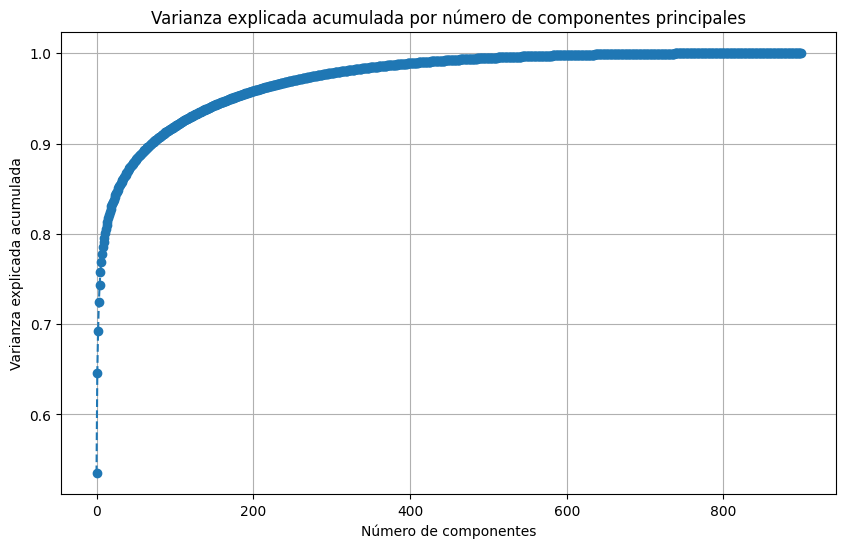

Número de componentes para retener el 90% de la varianza: 72
Número de componentes para retener el 95% de la varianza: 174
Número de componentes para retener el 99% de la varianza: 416


In [22]:
pca_audio = PCA()
pca_audio.fit(np.vstack(data['flatten_log_mel_spectogram']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_audio.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

In [23]:
pca = PCA(n_components=72)

In [24]:
converted = pca.fit_transform(np.vstack(data['flatten_log_mel_spectogram']))
converted = [row for row in converted]
data['pca_flatten_log_mel_spectogram'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram
patient,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.87453743909916, 39.473674991413205, -11...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984351, 109.95630385447593, -152...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.45664355671556, 48.46460586681956, 26.37..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596444, -30.185493257024223, -27.3..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379726, 92.81292282741705, 35.253..."


### <font color='#4C5FDA'>**2.3.2 Hipomimia**</font> <a name = "tema8">


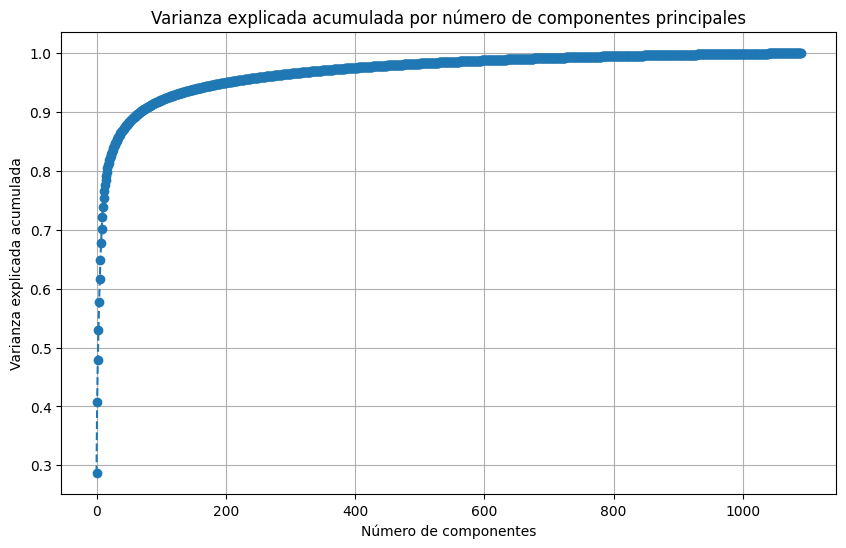

Número de componentes para retener el 90% de la varianza: 69
Número de componentes para retener el 95% de la varianza: 200
Número de componentes para retener el 99% de la varianza: 652


In [13]:
pca_video = PCA()
pca_video.fit(np.vstack(data['flatten_frame_sequence']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_video.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

In [25]:
pca = PCA(n_components=69)

In [26]:
converted = pca.fit_transform(np.vstack(data['flatten_frame_sequence']))
converted = [row for row in converted]
data['pca_flatten_frame_sequence'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram,pca_flatten_frame_sequence
patient,,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.87453743909916, 39.473674991413205, -11....","[-4.595280588132663, 24.683745586722914, 6.690..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984351, 109.95630385447593, -152....","[-3.864669403017602, 22.542839684109985, 7.230..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.45664355671556, 48.46460586681956, 26.37...","[-4.72019855782221, 23.37272236443247, 5.34050..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596444, -30.185493257024223, -27.3...","[1.1824708722405526, 26.16580498762466, 9.0497..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379726, 92.81292282741705, 35.253...","[-2.6796593130353346, 24.029221663542, 6.85672..."


### <font color='#4C5FDA'>**2.3.3 Fused**</font> <a name = "tema8">


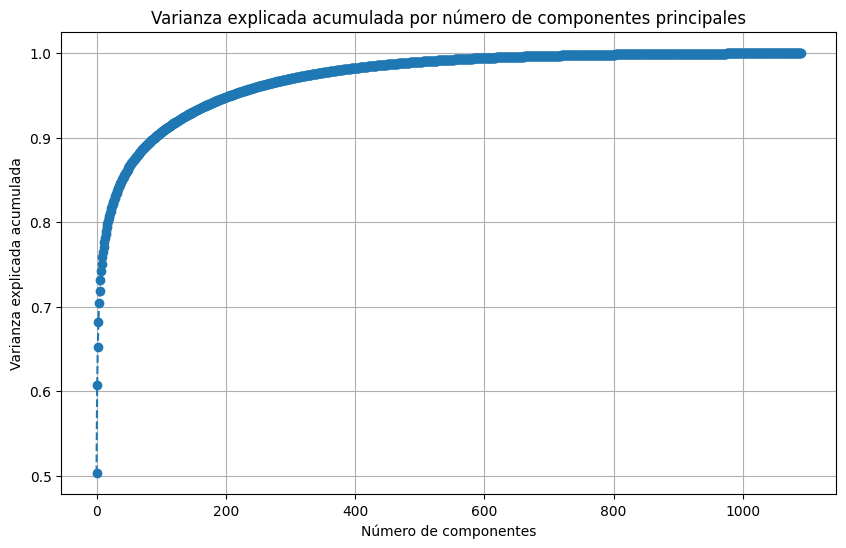

Número de componentes para retener el 90% de la varianza: 91
Número de componentes para retener el 95% de la varianza: 208
Número de componentes para retener el 99% de la varianza: 503


In [27]:
pca_fused = PCA()
pca_fused.fit(np.vstack(data['fused_flattened_features']))

# Varianza explicada acumulada
explained_variance_ratio = np.cumsum(pca_fused.explained_variance_ratio_)

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.grid(True)
plt.show()

# Imprimir el número de componentes para diferentes niveles de varianza explicada
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Número de componentes para retener el {int(threshold*100)}% de la varianza: {num_components}')

In [55]:
pca = PCA(n_components=91)

In [29]:
converted = pca.fit_transform(np.vstack(data['fused_flattened_features']))
converted = [row for row in converted]
data['pca_fused_flattened_features'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,flatten_frame_sequence,fused_flattened_features,pca_flatten_log_mel_spectogram,pca_flatten_frame_sequence,pca_fused_flattened_features
patient,,,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[0.44313725490196076, 0.4470588235294118, 0.44...","[0.44313725490196076, 0.4470588235294118, 0.44...","[-146.87453743909916, 39.473674991413205, -11....","[-4.595280588132663, 24.683745586722914, 6.690...","[-146.07385004409764, 39.71078323758914, -13.3..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[0.4627450980392157, 0.4627450980392157, 0.458...","[0.4627450980392157, 0.4627450980392157, 0.458...","[-214.1628682984351, 109.95630385447593, -152....","[-3.864669403017602, 22.542839684109985, 7.230...","[-213.3287823772534, 110.5580374868841, -149.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[0.4666666666666667, 0.4666666666666667, 0.474...","[0.4666666666666667, 0.4666666666666667, 0.474...","[-271.45664355671556, 48.46460586681956, 26.37...","[-4.72019855782221, 23.37272236443247, 5.34050...","[-270.53810520710374, 48.7851859269735, 23.169..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[0.44313725490196076, 0.44313725490196076, 0.4...","[0.44313725490196076, 0.44313725490196076, 0.4...","[80.03360474596444, -30.185493257024223, -27.3...","[1.1824708722405526, 26.16580498762466, 9.0497...","[80.63109017357371, -29.97129119405373, -27.91..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[0.4627450980392157, 0.45098039215686275, 0.45...","[0.4627450980392157, 0.45098039215686275, 0.45...","[-94.45165273379726, 92.81292282741705, 35.253...","[-2.6796593130353346, 24.029221663542, 6.85672...","[-93.74823690226754, 92.74274833807985, 33.705..."


# <font color='#4C5FDA'> **3. Non-supervised 🦾**</color> <a name="tema8">

In [30]:
algorithms = [
    ('kmeans', KMeans(n_clusters=2, n_init='auto')),
    # ('DBSCAN', DBSCAN(eps=0.5, min_samples=5)),
    ('ACWard', AgglomerativeClustering(n_clusters=2, linkage="ward")),
    ('ACAverage', AgglomerativeClustering(n_clusters=2, linkage="average")),
    ('ACSingle', AgglomerativeClustering(n_clusters=2, linkage="single")),
]

In [31]:
def calculate_metrics(y_true, y_pred):
    # metrics = {}

    accuracy = accuracy_score(y_true, y_pred)*100
    f1 = f1_score(y_true, y_pred)*100
    precision = precision_score(y_true, y_pred)*100
    recall = recall_score(y_true, y_pred)*100

    # metrics['accuracy'] = accuracy
    # metrics['f1_score'] = f1
    # metrics['precision'] = precision
    # metrics['recall'] = recall

    return f'accuracy {accuracy:.2f} f1 {f1:.2f}\n precision {precision:.2f} recall {recall:.2f}'

### <font color='#52F17F'> **Demostración Individual con audio**</color> <a name="tema9">

In [32]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [33]:
X = np.vstack(data['pca_flatten_log_mel_spectogram'])
y = data['label'].values

In [34]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [35]:
y_pred = kmeans.fit_predict(X) # Same as training with X

In [36]:
metrics = calculate_metrics(y_pred=y_pred, y_true=y)
print(metrics)

accuracy 56.65 f1 45.19
 precision 61.32 recall 35.78


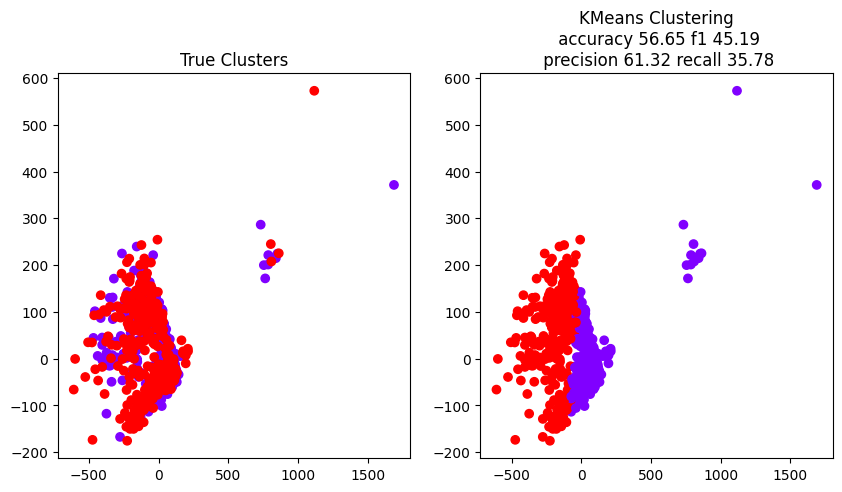

In [37]:
plt.figure(figsize=(10, 5))

# Dibujar los verdaderos clusters
plt.subplot(1, 2, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')
# Crear una subtrama para el resultado del clustering actual
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='rainbow')
plt.title(f'KMeans Clustering\n {metrics}')
plt.show()

## <font color='#EB9A54'> **3.1 Solo Audio Features**</color> <a name="tema8">

### <font color='#52F17F'> **3.1.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

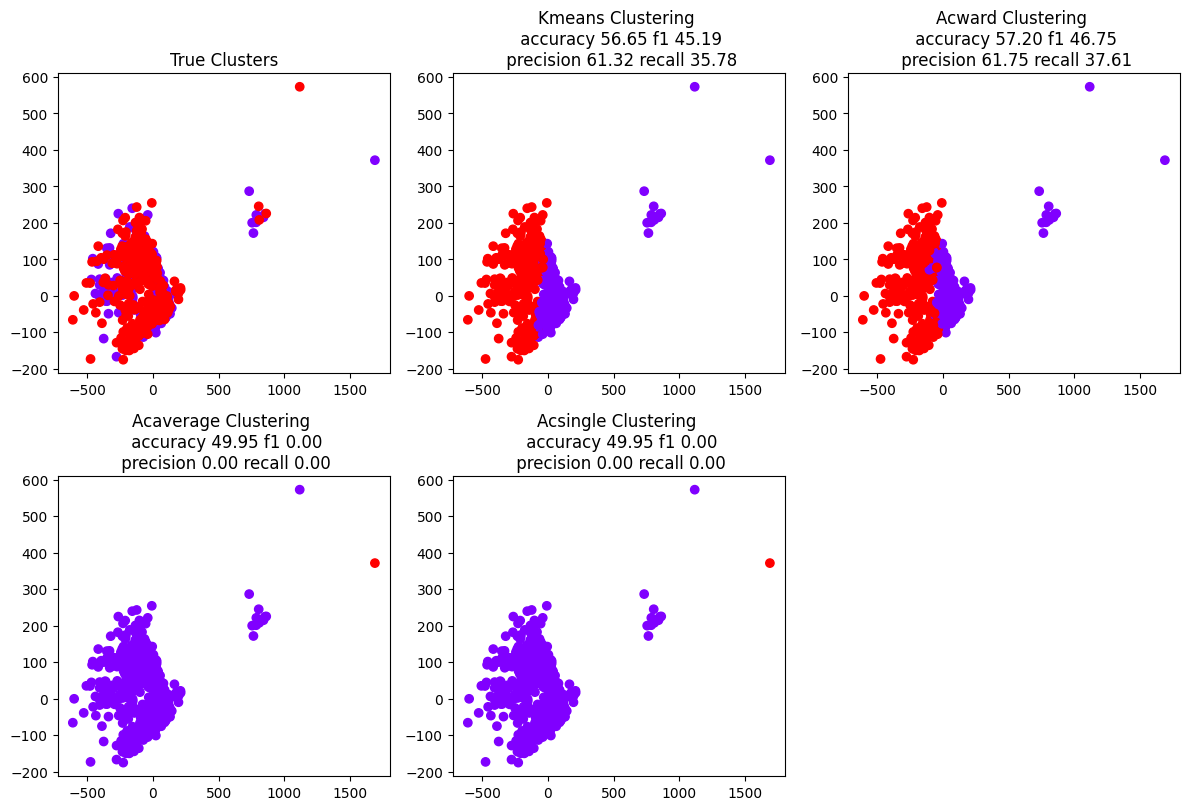

In [38]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()


## <font color='#EB9A54'> **3.2 Solo Video Features**</color> <a name="tema8">

### <font color='#52F17F'> **3.2.1 Prueba Individual**</color> <a name="tema8">

In [51]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [52]:
X = np.array(data['pca_flatten_frame_sequence'].tolist())
y = data['label'].values

In [53]:
kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto')

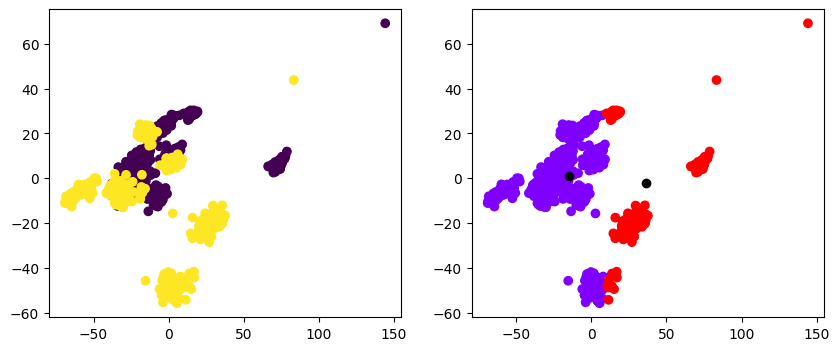

In [54]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

In [43]:
clusters = kmeans.fit_predict(X)
print(np.array(clusters).shape)

(1091,)


### <font color='#52F17F'> **3.2.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

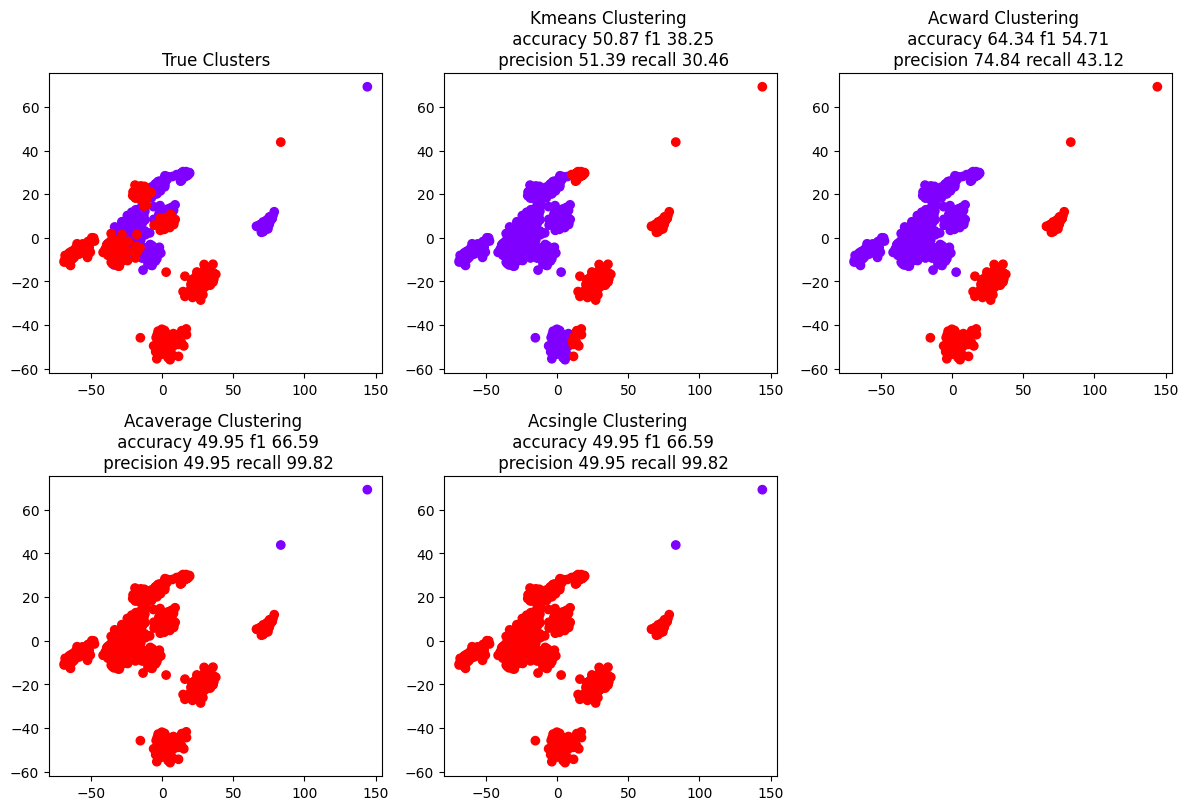

In [44]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()


## <font color='#EB9A54'> **3.3 Fusion of features**</color> <a name="tema8">

### <font color='#52F17F'> **3.3.1 Prueba Individual**</color> <a name="tema8">

In [45]:
kmeans = KMeans(n_clusters=2, n_init='auto')

In [46]:
X = np.array(data['pca_fused_flattened_features'].tolist())
y = data['label'].values

In [47]:
kmeans.fit(X)

KMeans(n_clusters=2, n_init='auto')

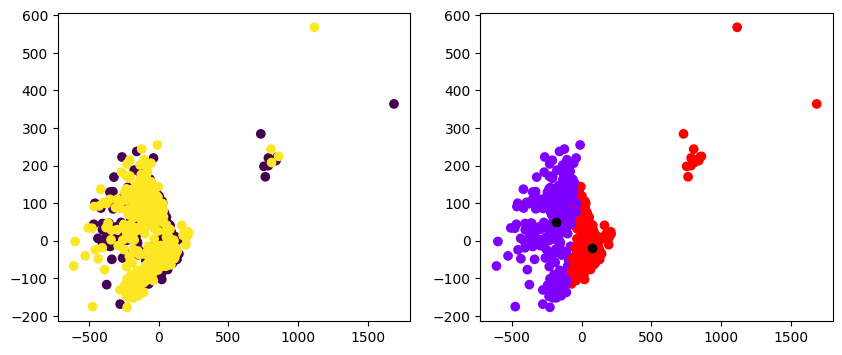

In [49]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(122)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

### <font color='#52F17F'> **3.3.2 Metricas para los diferentes Algoritmos de Clustering**</color> <a name="tema8">

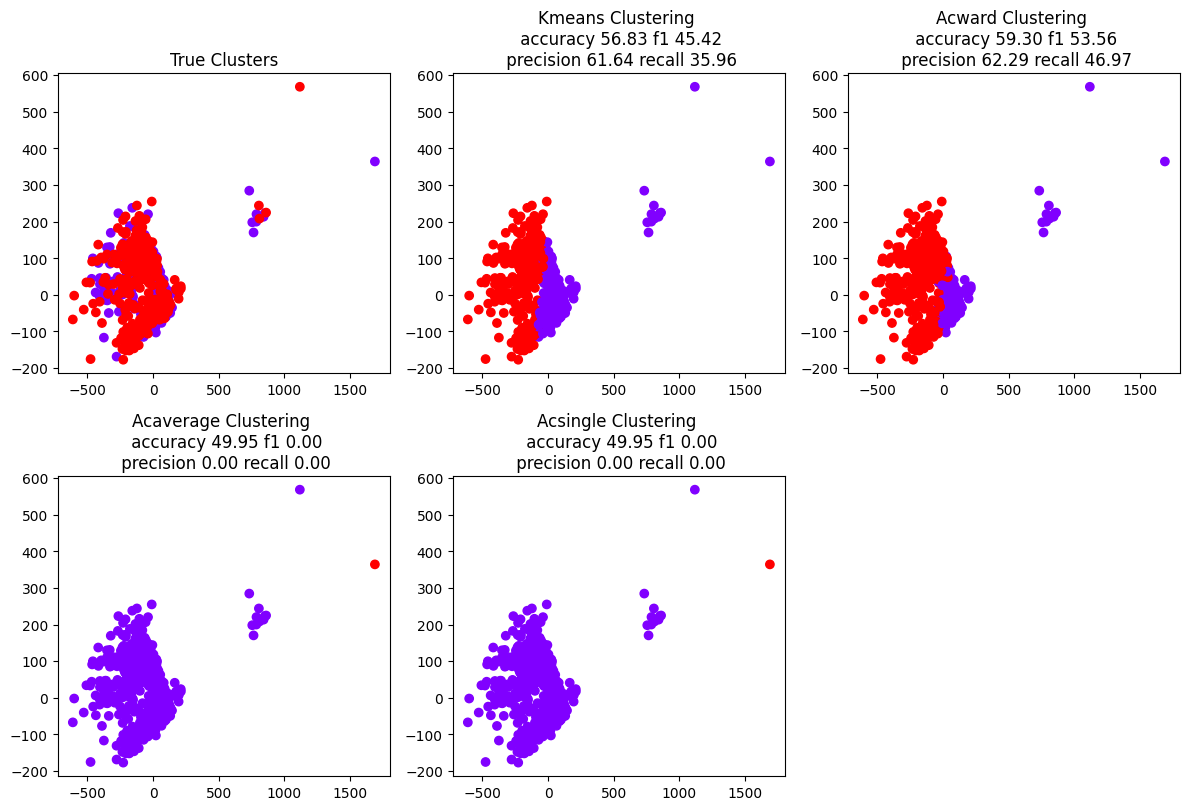

In [50]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Incrementar la altura para acomodar 3 filas

num_algorithms = len(algorithms)
num_columns = (num_algorithms + 1 + 2) // 2  # Calcular el número de columnas necesarias

# Dibujar los verdaderos clusters
plt.subplot(3, num_columns, 1)  # Ajustar para incluir la gráfica de clusters verdaderos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
plt.title('True Clusters')

# Iterar sobre cada algoritmo y aplicar el clustering
for i, (name, alg) in enumerate(algorithms):
    # Aplicar el algoritmo de clustering
    clusters = alg.fit_predict(X)

    # Calcular métricas
    metrics = calculate_metrics(y, clusters)

    plt.subplot(3, num_columns, i + 2)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow')

    # Título con el nombre del algoritmo y las métricas calculadas
    plt.title(f'{name.capitalize()} Clustering \n {metrics}')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()
plt.show()

# <font color='#4C5FDA'> **4. Bibliografía**</font>

* Mangale, S. (2021, 15 diciembre). Scree Plot - SANCHITA MANGALE - Medium. Medium. https://sanchitamangale12.medium.com/scree-plot-733ed72c8608
* PCA. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* KMeans. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans
* AgglomerativeClustering. (s. f.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
